# Imports básicos para todas as análises

In [137]:
# Desativar as mensagens de 'warning' que ficam poluindo o output aqui no Colab

import warnings
warnings.filterwarnings("ignore")

In [138]:
import  pandas as pd,               \
        numpy as np,                \
        matplotlib.pyplot as plt,   \
        requests as rt,             \
        seaborn as sns,             \
        xml.etree.ElementTree as ET

from matplotlib.pylab import rcParams
from pandas.plotting  import register_matplotlib_converters

from xgboost import XGBRegressor

from sklearn.metrics import r2_score, mean_squared_error

from sktime.utils.plotting import plot_series
#from sktime.forecasting.compose import make_reduction
#from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.performance_metrics.forecasting import MeanAbsolutePercentageError

# Ajustes feitos para geração e criação de gráfico
sns.set_style('darkgrid')
rcParams['figure.figsize'] = 15, 6

# Tratar conversões de DateTime entre o Pandas e o Matplotlib
register_matplotlib_converters()

# Symmetric Mean Absolute Percentage Error
smape = MeanAbsolutePercentageError(symmetric=True)

### Utilidades

In [139]:
# Retirado de: <https://github.com/Azure/DeepLearningForTimeSeriesForecasting/blob/master/common/utils.py>

from collections import UserDict

class TimeSeriesStructure(UserDict):
    """
    Use this class to:
      1. Shift the values of the time series to create a Pandas dataframe containing all the data
         for a single training example
      2. Discard any samples with missing values
      3. Transform this Pandas dataframe into a numpy array of shape
         (samples, time steps, features) for input into Keras

    The class takes the following parameters:
       - **dataset**: original time series
       - **target** name of the target column
       - **H**: the forecast horizon
       - **tensor_structures**: a dictionary discribing the tensor structure of the form
             { 'tensor_name' : (range(max_backward_shift, max_forward_shift), [feature, feature, ...] ) }
             if features are non-sequential and should not be shifted, use the form
             { 'tensor_name' : (None, [feature, feature, ...])}
       - **freq**: time series frequency (default 'H' - hourly)
       - **drop_incomplete**: (Boolean) whether to drop incomplete samples (default True)
    """

    def __init__(self, dataset, target, H, tensor_structure, freq='H', drop_incomplete=True):
        self.dataset = dataset
        self.target = target
        self.tensor_structure = tensor_structure
        self.tensor_names = list(tensor_structure.keys())

        self.dataframe = self._shift_data(H, freq, drop_incomplete)
        self.data = self._df2tensors(self.dataframe)

    def _shift_data(self, H, freq, drop_incomplete):

        # Use the tensor_structures definitions to shift the features in the original dataset.
        # The result is a Pandas dataframe with multi-index columns in the hierarchy
        #     tensor - the name of the input tensor
        #     feature - the input feature to be shifted
        #     time step - the time step for the RNN in which the data is input. These labels
        #         are centred on time t. the forecast creation time
        df = self.dataset.copy()

        idx_tuples = []
        for t in range(1, H+1):
            df['t+'+str(t)] = df[self.target].shift(t*-1, freq=freq)
            idx_tuples.append(('target', 'y', 't+'+str(t)))

        for name, structure in self.tensor_structure.items():
            rng = structure[0]
            dataset_cols = structure[1]

            for col in dataset_cols:

            # do not shift non-sequential 'static' features
                if rng is None:
                    df['context_'+col] = df[col]
                    idx_tuples.append((name, col, 'static'))

                else:
                    for t in rng:
                        sign = '+' if t > 0 else ''
                        shift = str(t) if t != 0 else ''
                        period = 't'+sign+shift
                        shifted_col = name+'_'+col+'_'+period
                        df[shifted_col] = df[col].shift(t*-1, freq=freq)
                        idx_tuples.append((name, col, period))

        df = df.drop(self.dataset.columns, axis=1)
        idx = pd.MultiIndex.from_tuples(idx_tuples, names=['tensor', 'feature', 'time step'])
        df.columns = idx

        if drop_incomplete:
            df = df.dropna(how='any')

        return df

    def _df2tensors(self, dataframe):

        # Transform the shifted Pandas dataframe into the multidimensional numpy arrays. These
        # arrays can be used to input into the keras model and can be accessed by tensor name.
        # For example, for a TimeSeriesTensor object named "model_inputs" and a tensor named
        # "target", the input tensor can be acccessed with model_inputs['target']

        inputs = {}
        y = dataframe['target']
        y = y.values
        inputs['target'] = y

        for name, structure in self.tensor_structure.items():
            rng = structure[0]
            cols = structure[1]
            tensor = dataframe[name][cols].values
            if rng is None:
                tensor = tensor.reshape(tensor.shape[0], len(cols))
            else:
                tensor = tensor.reshape(tensor.shape[0], len(cols), len(rng))
                tensor = np.transpose(tensor, axes=[0, 2, 1])
            inputs[name] = tensor

        return inputs

    def subset_data(self, new_dataframe):

        # Use this function to recreate the input tensors if the shifted dataframe
        # has been filtered.

        self.dataframe = new_dataframe
        self.data = self._df2tensors(self.dataframe)

In [140]:
class DataSet():
    
    def __init__(self, file, adjust=True):
        self.df = pd.read_csv(file, sep='\t', index_col=0, header=0, parse_dates=['ds'])

        if adjust:
            self.df = self.df.resample('D').first() # deixando a série contínua numa base diária
            self.df.fillna(self.df.mean(), inplace=True) # isso, possivelmente, criará lacunas com "NaN" e precisa executar este passo

        self.df_inputs = None # Este atributo receberá um objeto da classe "TimeSeriesStructure"
        
        self.df_train = None
        self.df_validation = None

        self.X = None
        self.y = None

        self.X_train = None
        self.y_train = None
        
        self.X_validation = None
        self.y_validation = None

    # O corte realizado por esse método é simples: pega do início da série até 'train_size' e coloca no DataFrame 'train'.
    # O que resta do corte é colocado no DataFrame 'validation'
    def split_train_test(self, dataframe, train_size=0.7):

        # Tamanho total da série
        size = dataframe.shape[0]

        # Tamanho do treino
        t_size = int(size * train_size)

        train = dataframe.iloc[0:t_size]
        validation = dataframe.iloc[t_size:]

        return train, validation

# Alto Doce

## Carregando os dados para análise

In [176]:
ds_alto = DataSet('alto_doce.csv')
ds_alto.df.describe()

,y,chuva1,vazao1,chuva2,vazao2,chuva3,vazao3,chuva4,vazao4,chuva5,vazao5,chuva6,vazao6
count,3683.000000,3683.00000,3683.000000,3683.000000,3683.000000,3683.000000,3683.000000,3683.000000,3683.000000,3683.000000,3683.000000,3683.000000,3683.000000
mean,120.963956,2.90080,69.662090,2.667560,71.762139,2.295398,28.032810,0.045096,254.083439,2.877480,115.548849,3.277873,61.976891
std,123.811284,9.48174,65.914976,7.136782,59.072915,5.834512,28.915250,0.449132,2.527514,7.864615,110.591662,8.015500,60.153906
min,17.410000,0.00000,9.791935,0.000000,0.000000,0.000000,0.000000,0.000000,190.820000,0.000000,21.340000,0.000000,10.058000
25%,59.818000,0.00000,30.884896,0.000000,39.444375,0.000000,10.192120,0.000000,254.035853,0.000000,71.138043,0.000000,29.494000
50%,85.107000,0.00000,52.265625,2.100000,71.762139,1.400000,28.032810,0.000000,254.035853,2.000000,115.548849,3.277873,45.371000
75%,134.837000,0.40000,74.283958,2.667560,71.762139,2.295398,30.081330,0.045096,254.083439,2.877480,115.548849,3.277873,65.381000
max,2000.467000,139.20000,806.008148,111.200000,949.781250,100.000000,261.545833,16.700000,377.050000,192.200000,1936.280000,172.400000,849.711000


In [177]:
ds_alto.df

,y,chuva1,vazao1,chuva2,vazao2,chuva3,vazao3,chuva4,vazao4,chuva5,vazao5,chuva6,vazao6
ds,,,,,,,,,,,,,
2013-01-01,82.787,0.0,49.475000,2.66756,71.762139,2.295398,28.032810,0.045096,254.083439,2.87748,115.548849,3.277873,60.056000
2013-01-02,80.489,0.0,46.957143,2.66756,71.762139,2.295398,28.032810,0.045096,254.083439,2.87748,115.548849,3.277873,37.546000
2013-01-03,78.214,0.0,46.721875,2.66756,71.762139,2.295398,28.032810,0.045096,254.083439,2.87748,115.548849,3.277873,39.228000
2013-01-04,79.349,0.0,49.183333,2.66756,71.762139,2.295398,28.032810,0.045096,254.083439,2.87748,115.548849,3.277873,37.546000
2013-01-05,129.161,0.0,49.780208,2.66756,71.762139,2.295398,28.032810,0.045096,254.083439,2.87748,115.548849,3.277873,39.228000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-27,648.940,0.8,388.402708,0.80000,369.873333,2.400000,120.202917,0.000000,311.915263,0.00000,565.199583,0.200000,61.976891
2023-01-28,520.591,0.0,263.569896,0.00000,244.310833,0.000000,111.370833,0.000000,243.242500,2.60000,387.516250,0.000000,61.976891
2023-01-29,424.853,0.0,242.208229,0.00000,216.592083,0.000000,93.840417,0.000000,190.820000,0.00000,321.508333,0.000000,61.976891


## Análise exploratória dos dados

### Decomposição da Série Temporal da vazão 'y' (estação principal)

A decomposição da série temporal principal ('y'/'target') ajuda a detectar padrões e identificar outras informações que podem ajudar na interpretação do que está acontecendo

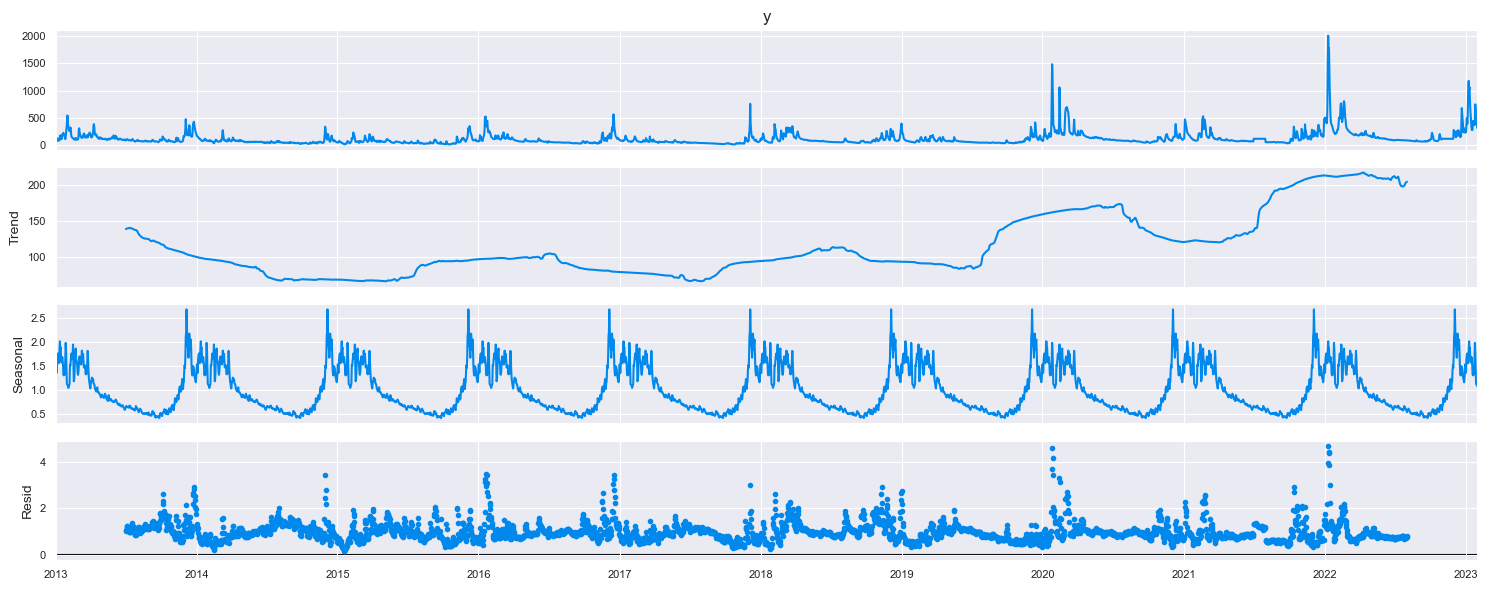

In [178]:
from statsmodels.tsa.seasonal import seasonal_decompose

vazao_y = seasonal_decompose(ds_alto.df['y'], period=365, model="mult")
vazao_y.plot() ; # este ';' é macetão pra não plotar duplicado este gráfico.

### Teste de estacionariedade da vazão 'y'

Novamente. Identificar informações, comportamento da Série Temporal em anaálise

In [144]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(ds_alto.df['y'])

if result[1] <= 0.05:
    print("ESTACIONÁRIA")
else:
    print("NÃO ESTACIONÁRIA")

ESTACIONÁRIA


In [145]:
# Mapa de correlação do DataFrame
ds_alto.df.corr().style.background_gradient(cmap='coolwarm')

,y,chuva1,vazao1,chuva2,vazao2,chuva3,vazao3,chuva4,vazao4,chuva5,vazao5,chuva6,vazao6
y,1.000000,0.268765,0.925556,0.268953,0.864723,0.246664,0.405192,-0.039812,0.069295,0.181228,0.886830,0.187818,0.845410
chuva1,0.268765,1.000000,0.270683,0.552330,0.225275,0.492518,0.205762,0.032928,-0.001726,0.390331,0.266706,0.399461,0.271507
vazao1,0.925556,0.270683,1.000000,0.238439,0.857252,0.225226,0.398863,-0.041772,0.084366,0.178644,0.844699,0.207285,0.870007
chuva2,0.268953,0.552330,0.238439,1.000000,0.246980,0.597748,0.268420,0.086183,-0.003044,0.532358,0.315741,0.403620,0.180795
vazao2,0.864723,0.225275,0.857252,0.246980,1.000000,0.202504,0.404864,-0.038198,0.090402,0.162788,0.928386,0.201542,0.753145
chuva3,0.246664,0.492518,0.225226,0.597748,0.202504,1.000000,0.264566,0.089278,-0.000904,0.519031,0.262896,0.293118,0.174690
vazao3,0.405192,0.205762,0.398863,0.268420,0.404864,0.264566,1.000000,-0.041096,0.046113,0.213777,0.405526,0.149993,0.306674
chuva4,-0.039812,0.032928,-0.041772,0.086183,-0.038198,0.089278,-0.041096,1.000000,-0.001068,0.083350,-0.038392,0.029414,-0.041734
vazao4,0.069295,-0.001726,0.084366,-0.003044,0.090402,-0.000904,0.046113,-0.001068,1.000000,-0.001990,0.074197,-0.004194,-0.001247
chuva5,0.181228,0.390331,0.178644,0.532358,0.162788,0.519031,0.213777,0.083350,-0.001990,1.000000,0.211561,0.287275,0.177663


In [146]:
# Usando o sweetviz para avaliar
# import sweetviz as sv
# analyze_report = sv.analyze(ds_alto.df)
# analyze_report.show_html('analyze.html', open_browser=True)

# Apresentando os resultados
# import IPython
# IPython.display.HTML('analyze.html')

Após análise com ajuda do SweetViz, removi as colunas "chuva4" e "vazao4" porque, de tanta lacuna e preenchimento com média,<br/>
elas foram detectadas como categóricas e pouco tinham de relação com as demais informações.

In [147]:
ds_alto.df.drop(columns=["chuva4", "vazao4"], inplace=True)

In [179]:
# ds_alto.df

### Formatando os dados para o Aprendizado Supervisionado

In [149]:
# Parâmetros para gerar um objeto TimeSeriesStructure

T = 5 # usará X lag(s) anterior(es)
HORIZON = 1 # vai prever Y dia(s) à frente
N_FEATURES = ds_alto.df.columns.size # As features são todas as colunas do dataset com os dados de todas as estações juntos

In [150]:
data_structure = {'X' : (range(-T+1, 1), ds_alto.df.columns.values)}
data_structure

{'X': (range(-4, 1),
  array(['y', 'chuva1', 'vazao1', 'chuva2', 'vazao2', 'chuva3', 'vazao3',
         'chuva5', 'vazao5', 'chuva6', 'vazao6'], dtype=object))}

In [151]:
ds_alto.df_inputs = TimeSeriesStructure(ds_alto.df, 'y', HORIZON, tensor_structure=data_structure, freq='D')

ds_alto.X = ds_alto.df_inputs.dataframe['X']
ds_alto.y = ds_alto.df_inputs.dataframe['target']

ds_alto.df_inputs.dataframe

tensor       target        X                                                   \
feature           y        y                                     chuva1         
time step       t+1      t-4      t-3      t-2      t-1        t    t-4   t-3   
ds                                                                              
2013-01-05  117.231   82.787   80.489   78.214   79.349  129.161    0.0   0.0   
2013-01-06   93.402   80.489   78.214   79.349  129.161  117.231    0.0   0.0   
2013-01-07   91.005   78.214   79.349  129.161  117.231   93.402    0.0   0.0   
2013-01-08   87.450   79.349  129.161  117.231   93.402   91.005    0.0   0.0   
2013-01-09   87.450  129.161  117.231   93.402   91.005   87.450    0.0   0.0   
...             ...      ...      ...      ...      ...      ...    ...   ...   
2023-01-26  648.940  370.758  422.803  376.640  472.934  749.032    2.8   0.2   
2023-01-27  520.591  422.803  376.640  472.934  749.032  648.940    0.2   4.2   
2023-01-28  424.853  376.640  472.934  749.032  648.940  520.591    4.2  54.4   
2023-01-29  362.965  472.934  749.032  648.940  520.591  424.853   54.4   1.0   
2023-01-30  316.521  749.032  648.940  520.591  424.853  362.965    1.0   0.8   

tensor                  ...                                             \
feature                 ...     chuva6                                   
time step    t-2   t-1  ...        t-4        t-3        t-2       t-1   
ds                      ...                                              
2013-01-05   0.0   0.0  ...   3.277873   3.277873   3.277873  3.277873   
2013-01-06   0.0   0.0  ...   3.277873   3.277873   3.277873  3.277873   
2013-01-07   0.0   0.0  ...   3.277873   3.277873   3.277873  3.277873   
2013-01-08   0.0   0.0  ...   3.277873   3.277873   3.277873  3.277873   
2013-01-09   0.0   0.0  ...   3.277873   3.277873   3.277873  3.277873   
...          ...   ...  ...        ...        ...        ...       ...   
2023-01-26   4.2  54.4  ...   1.600000  46.200000  12.200000  3.600000   
2023-01-27  54.4   1.0  ...  46.200000  12.200000   3.600000  0.000000   
2023-01-28   1.0   0.8  ...  12.200000   3.600000   0.000000  0.200000   
2023-01-29   0.8   0.0  ...   3.600000   0.000000   0.200000  0.000000   
2023-01-30   0.0   0.0  ...   0.000000   0.200000   0.000000  0.000000   

tensor                                                                       
feature                  vazao6                                              
time step          t        t-4        t-3        t-2        t-1          t  
ds                                                                           
2013-01-05  3.277873  60.056000  37.546000  39.228000  37.546000  39.228000  
2013-01-06  3.277873  37.546000  39.228000  37.546000  39.228000  39.228000  
2013-01-07  3.277873  39.228000  37.546000  39.228000  39.228000  38.383000  
2013-01-08  3.277873  37.546000  39.228000  39.228000  38.383000  32.714000  
2013-01-09  3.277873  39.228000  39.228000  38.383000  32.714000  29.671000  
...              ...        ...        ...        ...        ...        ...  
2023-01-26  0.000000  61.976891  61.976891  61.976891  61.976891  61.976891  
2023-01-27  0.200000  61.976891  61.976891  61.976891  61.976891  61.976891  
2023-01-28  0.000000  61.976891  61.976891  61.976891  61.976891  61.976891  
2023-01-29  0.000000  61.976891  61.976891  61.976891  61.976891  61.976891  
2023-01-30  0.000000  61.976891  61.976891  61.976891  61.976891  61.976891  

[3678 rows x 56 columns]

In [152]:
# Separando em TREINO e VALIDAÇÃO
ds_alto.df_train, ds_alto.df_validation = ds_alto.split_train_test(ds_alto.df_inputs.dataframe, 0.8)

ds_alto.X_train = ds_alto.df_train['X']
ds_alto.y_train = ds_alto.df_train['target']

ds_alto.X_validation = ds_alto.df_validation['X']
ds_alto.y_validation = ds_alto.df_validation['target']

ds_alto.X_train.shape, ds_alto.y_train.shape, ds_alto.X_validation.shape, ds_alto.y_validation.shape

((2942, 55), (2942, 1), (736, 55), (736, 1))

#### XGBoost

In [171]:
m_xgb = XGBRegressor(colsample_bytree=1, max_depth=500, min_child_weight=0, subsample=0.5)
m_xgb.fit(ds_alto.X_train, ds_alto.y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=500, max_leaves=None,
             min_child_weight=0, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [172]:
pred_xgb = pd.DataFrame(data=m_xgb.predict(ds_alto.X_validation), columns=['pred'])
pred_xgb['obs'] = pd.DataFrame(data=ds_alto.y_validation.values)

(0.16872084480257038, 0.7964950879442474, 89.00438499560799)

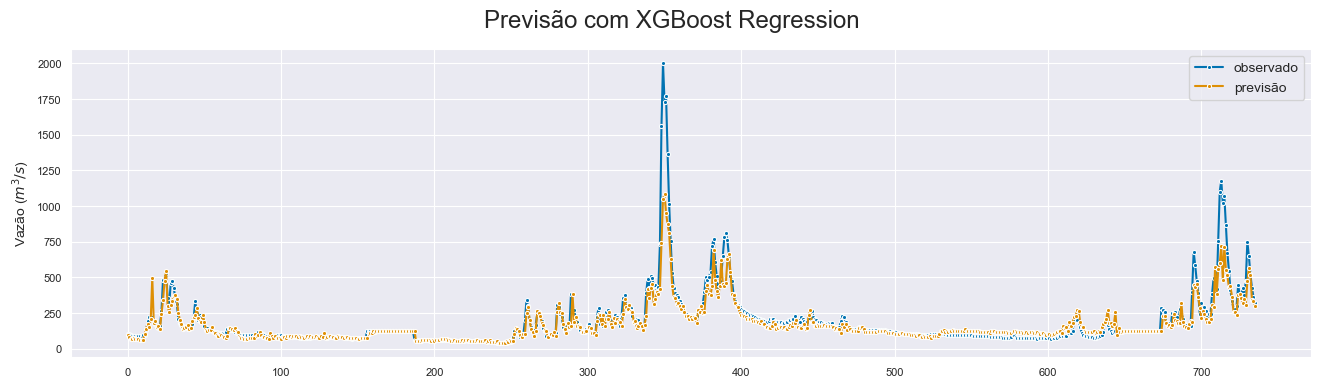

In [173]:
plot_series(pred_xgb['obs'], pred_xgb['pred'],
            labels=["observado", "previsão"],
            x_label='',
            y_label='Vazão ($m^3/s$)',
            title='Previsão com XGBoost Regression')

smape(pred_xgb['obs'], pred_xgb['pred']), r2_score(pred_xgb['obs'], pred_xgb['pred']), np.sqrt(mean_squared_error(pred_xgb['obs'], pred_xgb['pred']))

#### Otimizar o modelo XGBRegressor

**Tree-specific hyperparameters control the construction and complexity of the decision trees:**

<u>max_depth</u>: maximum depth of a tree. Deeper trees can capture more complex patterns in the data, but may also lead to overfitting. <<range: [0,∞]>>

<u>min_child_weight</u>: minimum sum of instance weight (hessian) needed in a child. This can be used to control the complexity of the decision tree by preventing the creation of too small leaves. <<range: [0,∞]>>

<u>subsample</u>: percentage of rows used for each tree construction. Lowering this value can prevent overfitting by training on a smaller subset of the data. <<range: (0,1]>>

<u>colsample_bytree</u>: percentage of columns used for each tree construction. Lowering this value can prevent overfitting by training on a subset of the features. <<range: (0, 1]>>
<br/><br/><br/><br/>
**Learning task-specific hyperparameters control the overall behavior of the model and the learning process:**

<u>eta (also known as learning rate)</u>: step size shrinkage used in updates to prevent overfitting. Lower values make the model more robust by taking smaller steps. <<range: [0,1]>>

<u>gamma</u>: minimum loss reduction required to make a further partition on a leaf node of the tree. Higher values increase the regularization. <<range: [0,∞]>>

<u>lambda</u>: L2 regularization term on weights. Higher values increase the regularization. <<range: [0,∞]>>

<u>alpha</u>: L1 regularization term on weights. Higher values increase the regularization. <<range: [0,∞]>>

In [167]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
import scipy.stats as stats

In [169]:
rand_params = {
    # 'n_estimators' : stats.randint(10, 1000),
    'max_depth' : stats.randint(1, 1000),
    'min_child_weight' : stats.uniform(0, 1000),
    'subsample' : [0.01, 0.25, 0.5, 0.75, 1],
    'colsample_bytree' : [0.01, 0.25, 0.5, 0.75, 1],
    # 'learning_rate' : [1e-4, 1e-3, 1e-2, 1e-1, 1e-0],
    # 'gamma' : stats.uniform(0, 1000),
    # 'reg_lambda' : stats.uniform(0, 1000),
    # 'alpha' : stats.uniform(0, 1000),
}

xgb_model = XGBRegressor()

cv = TimeSeriesSplit(n_splits=7)

rand_search = RandomizedSearchCV(xgb_model, param_distributions=rand_params, n_jobs=-1, n_iter=50, cv=cv, scoring='neg_mean_squared_error')
rand_search.fit(ds_alto.X_train, ds_alto.y_train)

print("Best set of hyperparameters: ", rand_search.best_params_)
print("Best score: ", rand_search.best_score_)

Best set of hyperparameters:  {'colsample_bytree': 0.5, 'max_depth': 548, 'min_child_weight': 21.66987568139822, 'subsample': 1}
Best score:  -2217.211684816797


In [175]:
# np.random.randint(low = 0, high=1000, size=5)
# np.random.random_sample(size=7)

In [174]:
grid_params = {
    # 'max_depth' : [0, 500, 1000, 1500, 2000],
    # 'min_child_weight' : [0, 250, 500, 750, 1000],
    # 'subsample' : [0.01, 0.25, 0.5, 0.75, 1],
    # 'colsample_bytree' : [0.01, 0.25, 0.5, 0.75, 1],
    'learning_rate' : [1e-4, 1e-3, 1e-2, 1e-1, 1e-0],
    'gamma' : [0, 500, 1000, 1500, 2000],
    'reg_lambda' : [0, 500, 1000, 1500, 2000],
    'alpha' : [0, 500, 1000, 1500, 2000],
}

xgb_model = XGBRegressor()

cv = TimeSeriesSplit(n_splits=7)

grid_search = GridSearchCV(xgb_model, param_grid=grid_params, n_jobs=-1, cv=cv, scoring='neg_mean_squared_error')
grid_search.fit(ds_alto.X_train, ds_alto.y_train)

print("Best set of hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best set of hyperparameters:  {'alpha': 0, 'gamma': 500, 'learning_rate': 0.1, 'reg_lambda': 0}
Best score:  -1945.026376997648


#### Rede LSTM

Aplicação da biblioteca NeuralForecast

# Médio Doce

# Baixo Doce